In [13]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging
import ipynb
import decimal

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

# importing my model functions for analysis
from psi_transmission.model_functions import *

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# some data loads to be performed right away
start_time_dict = get_start_times()
main_data_dict = load_all_data(start_time_dict['edgard_p_beam'])

main_data_dict

# Measuring Total UCN Counts per Nominal Run; by Pre-Storage Time

By 'nominal' I refer to the guide-less configuration, pictured below (from Edgard's slides).

![](../misc/nominal_configuration.png)
![](jonahberean/psi_transmission/misc/nominal_configuration.png)

In this section, only the runs carried out in this configuration are used. Transmission ratios were found by Edgard to be ~0.5-0.9 for the various guides, and these measurements would need to be used in a re-normalization of the absolute counts before any comparison with nominal configuration runs.

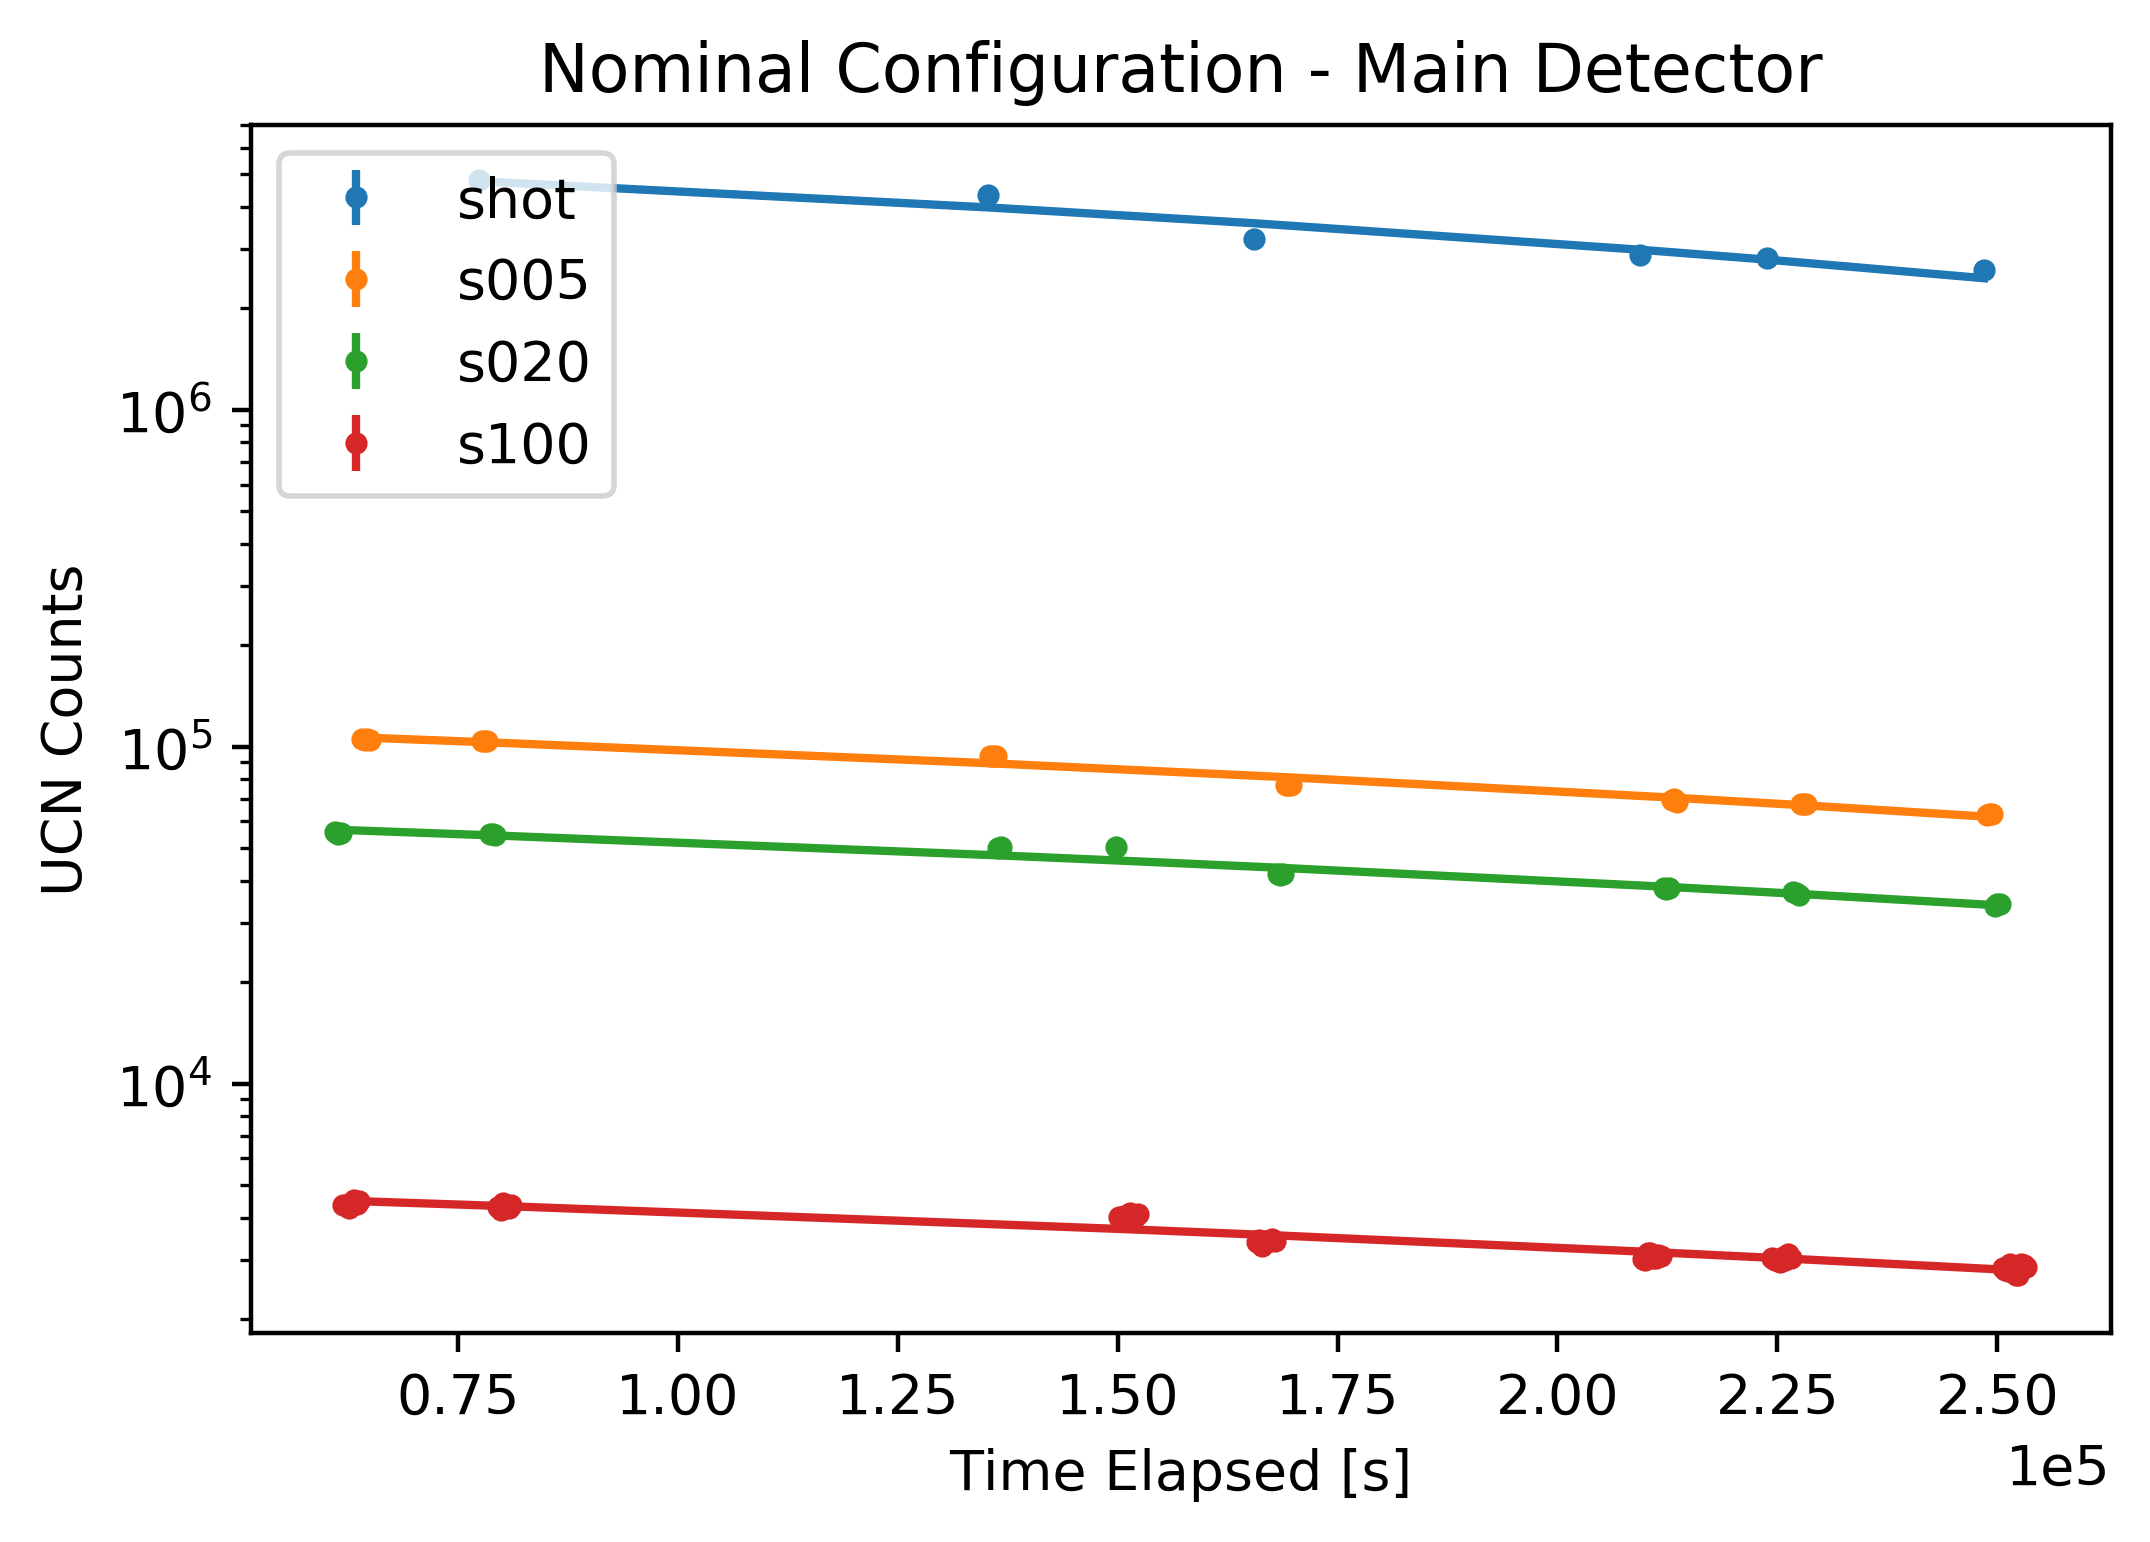

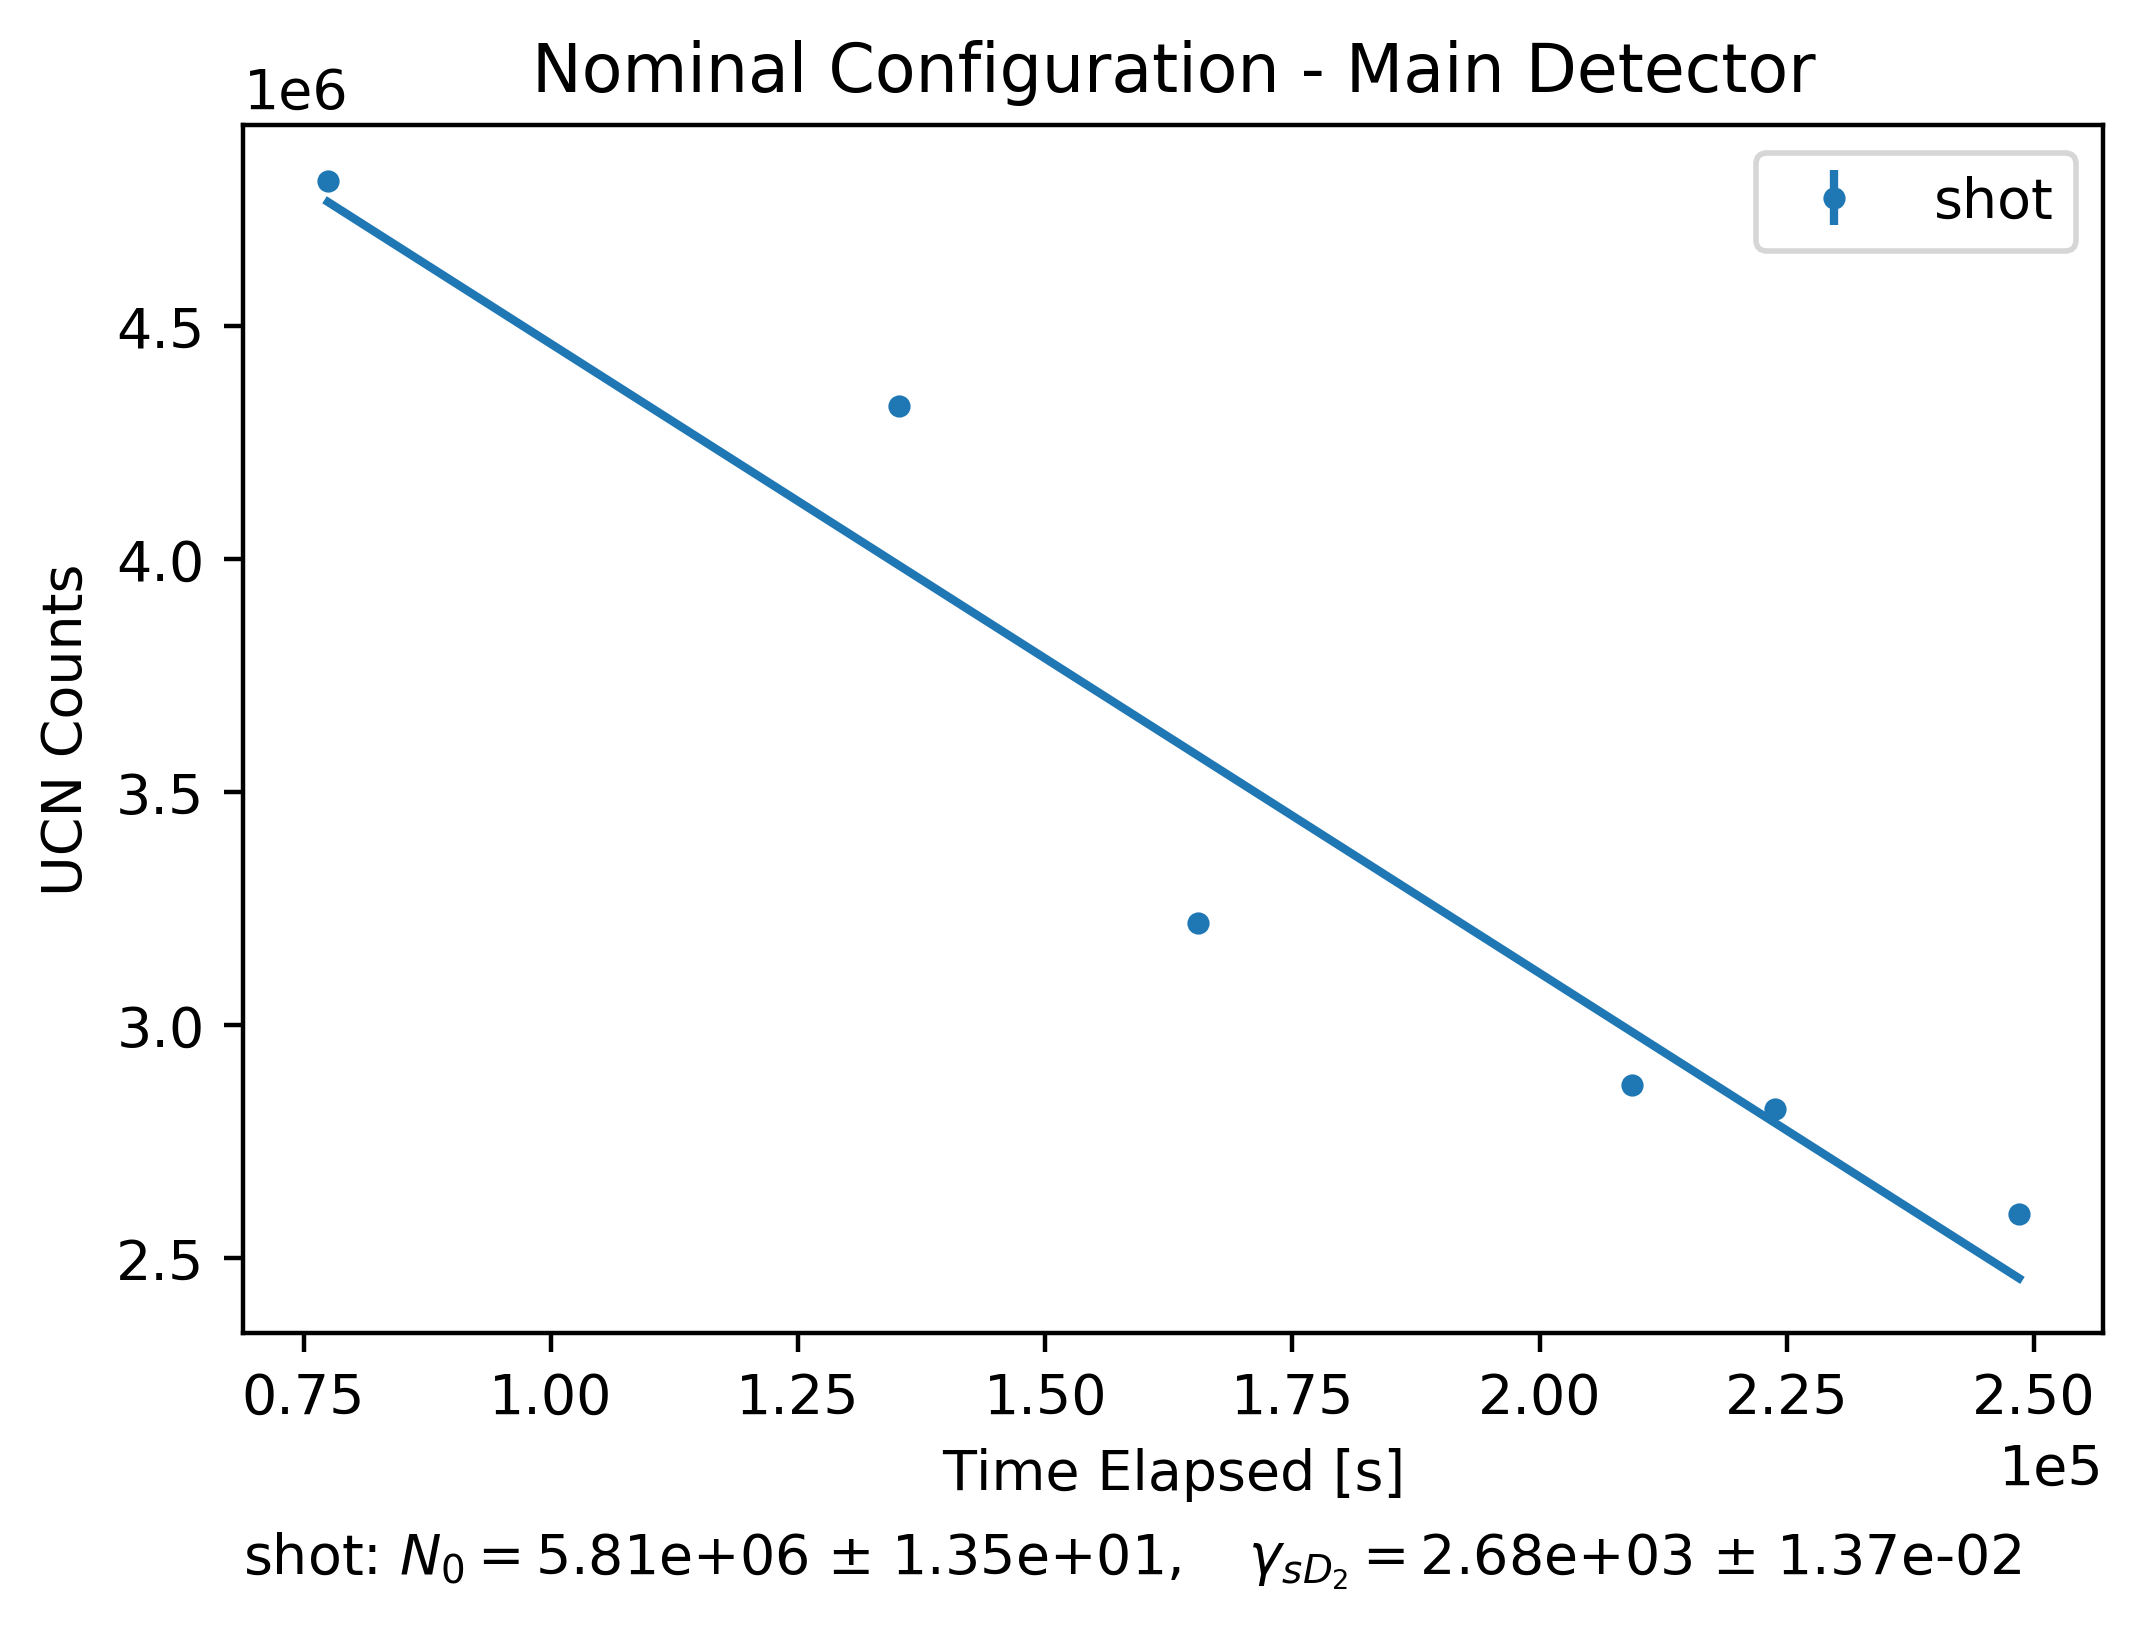

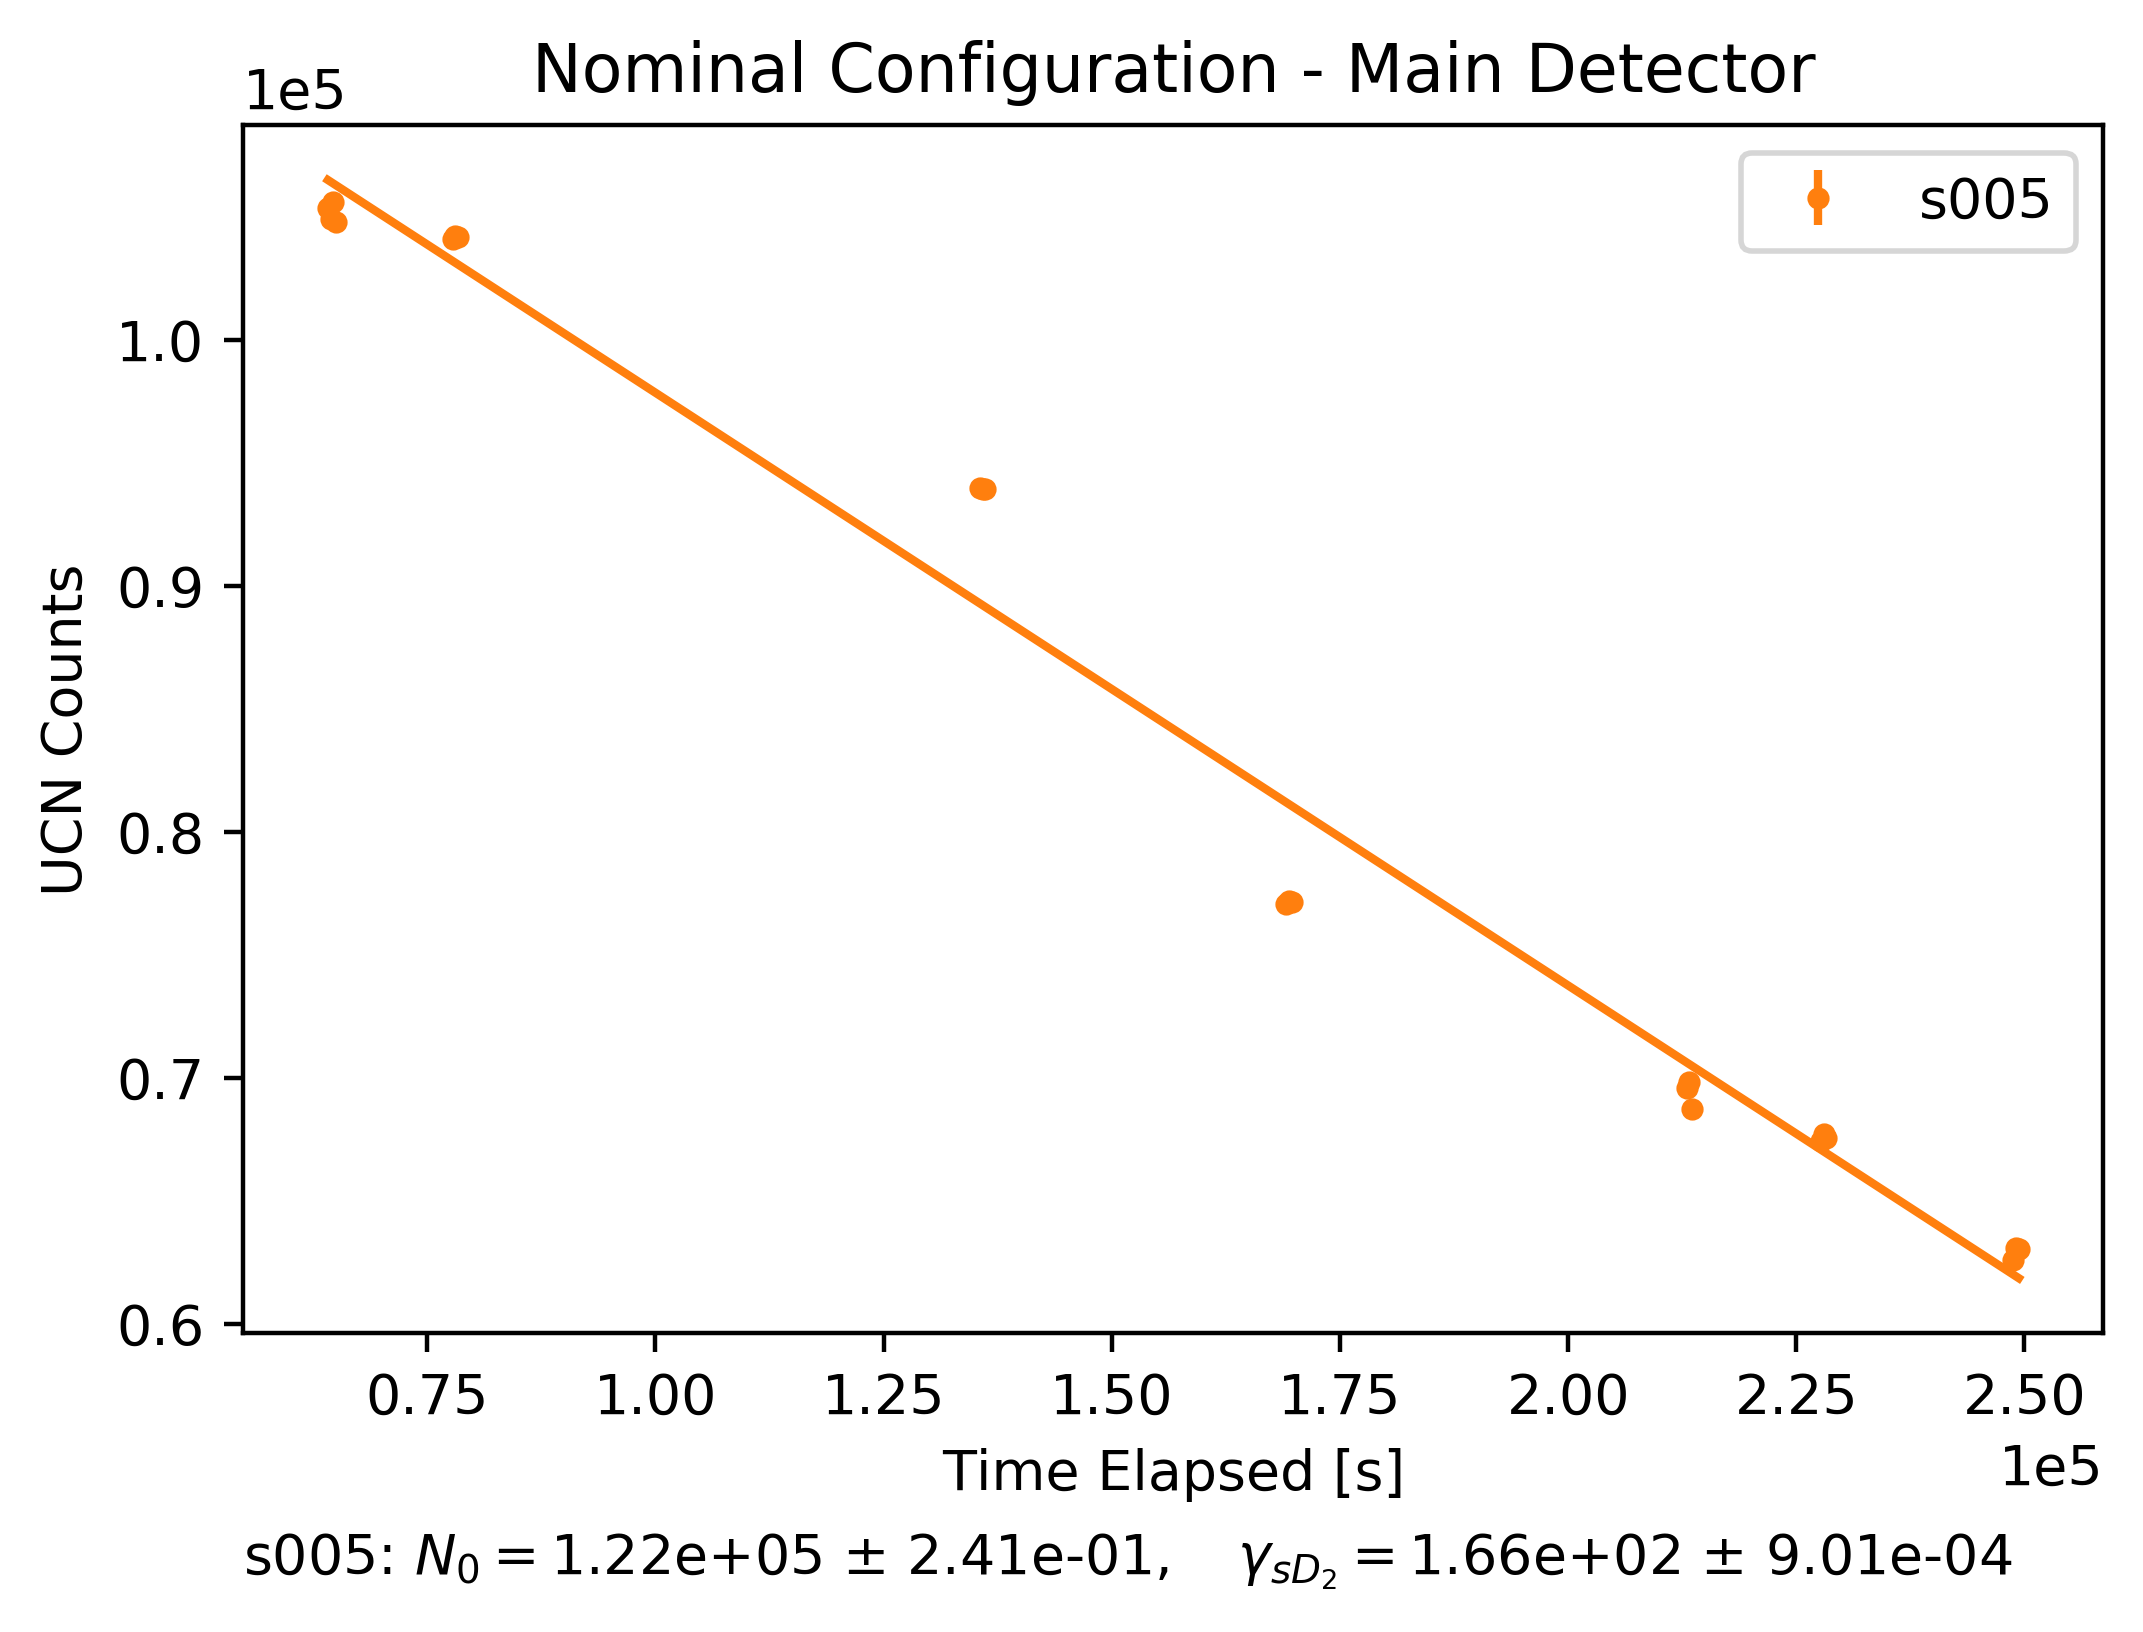

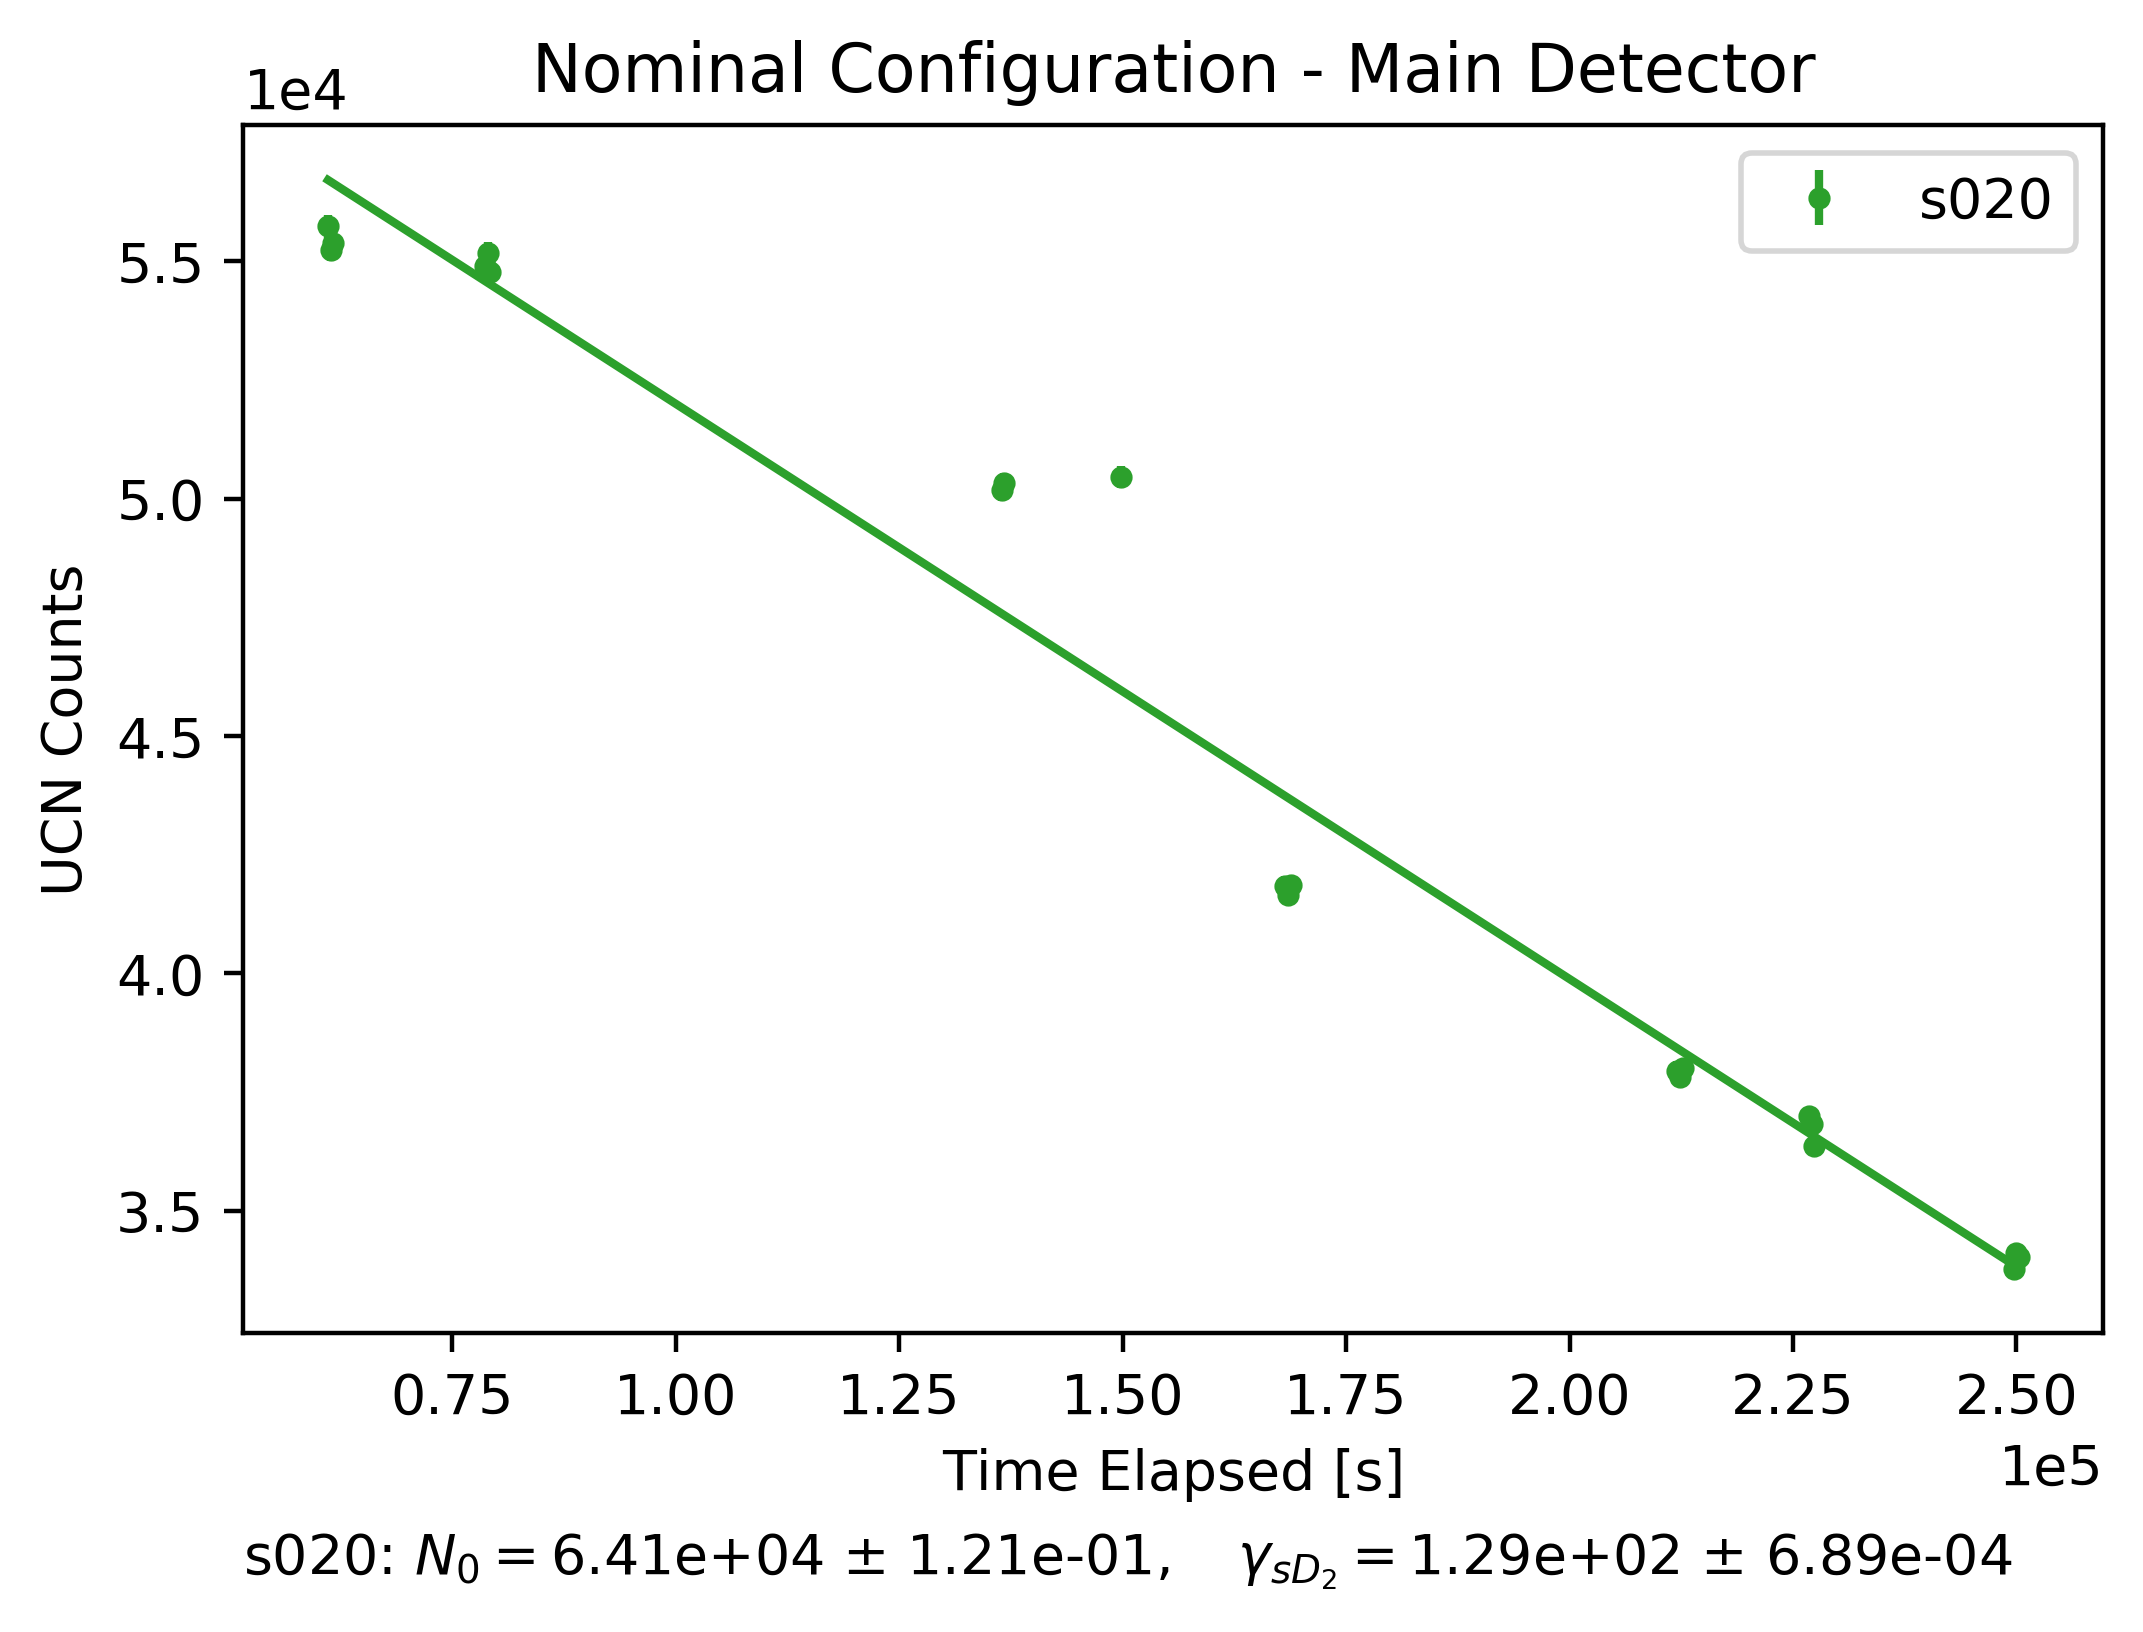

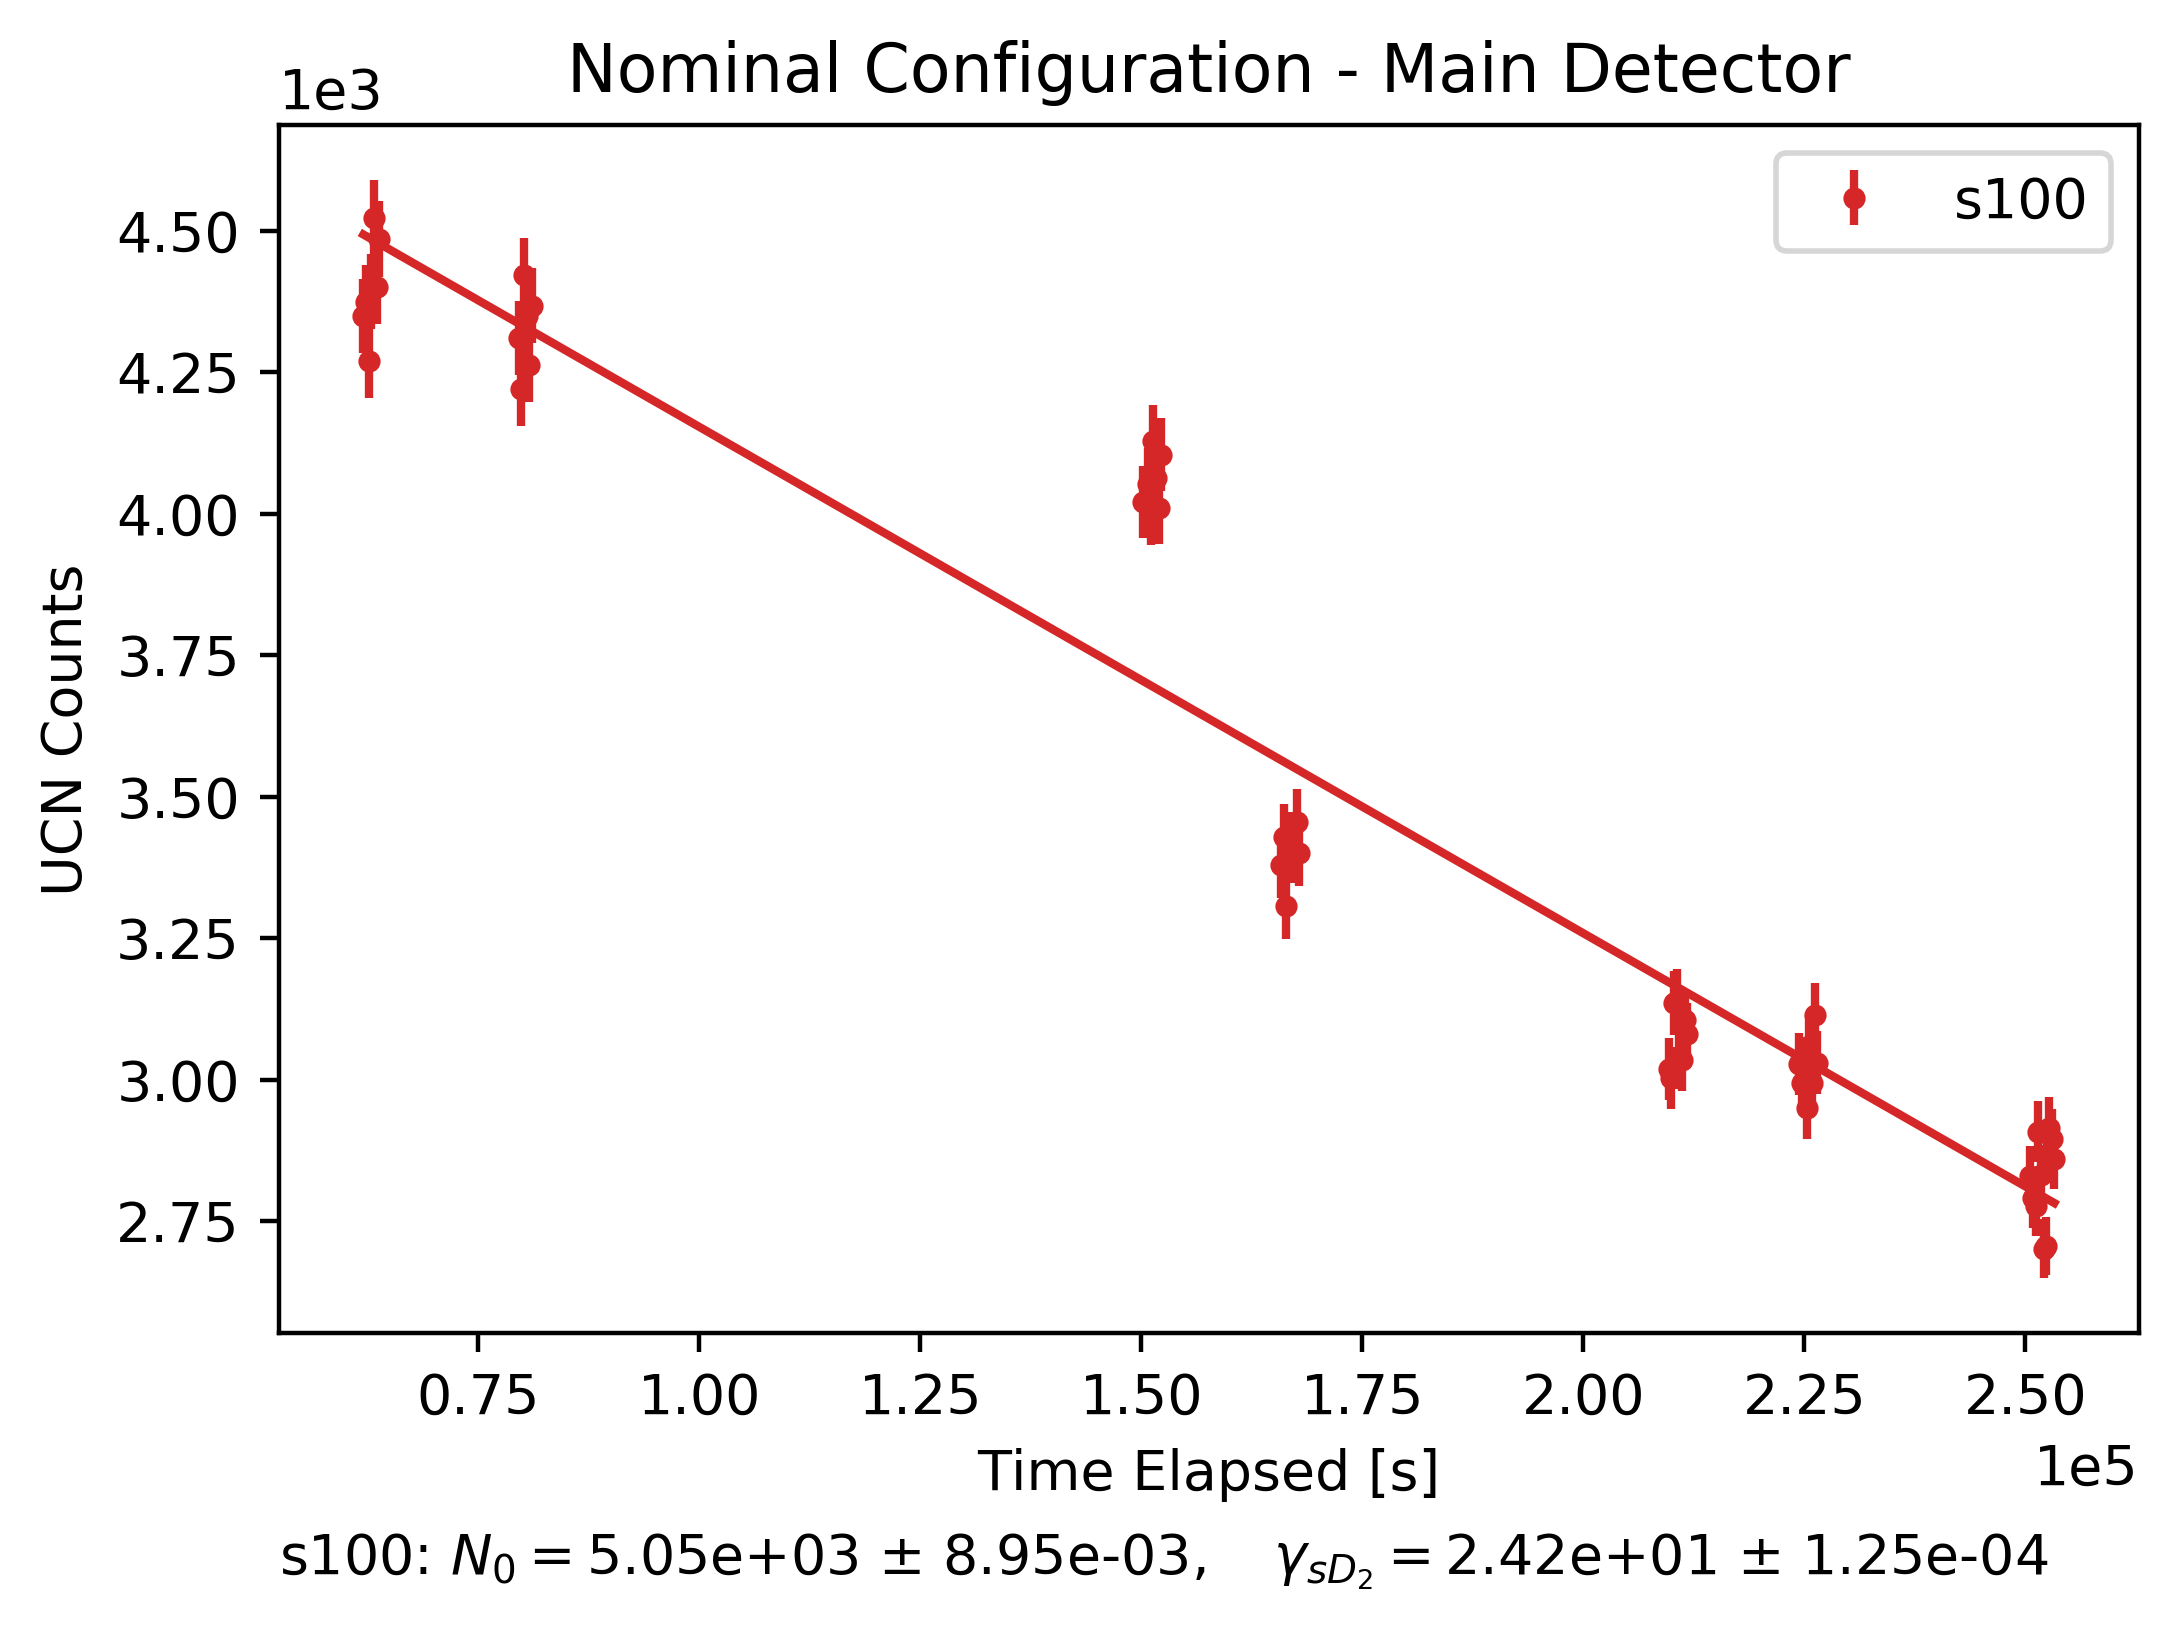

In [26]:
norm_dict = ucn_yield(main_data_dict, plotting_flag = True);

The error bar v. spread of the data suggests that there are systematic effects at play here that are not being properly accounted for with this simplistic linear model of sD2 degradation.

# Comparing UCN Count Degradation Rates for Different Pre-Storage Times

In order to compare the degradation rates - the slopes from the most recent figure - the rates must be re-scaled by the absolute count rates at time $t = 0$, the beginning of the experiment. 

Here the fit function is a simple linear model, 

$$N(t) = N_0 - \gamma_{sD_2} t$$

where $N_0$ would be the extrapolated number of counts for a hypothetical storage time at $t=0$. Here we define the $t=0$ time to be the start of the proton beam current measurements, as this is simply the earliest time stamp we have had to consider in the analysis of this experiment. The parameter $\gamma_{sD_2}$ is the loss rate of absolute UCN counts over time. Here the lowercase $\gamma$ is used to differentiate this rate from the characteristic decay rate $\Gamma$ of a single UCN.

In the figure below, the four fits to the nominal configuration data are plotted once more, but every data point (representing total counts in a given run) and its associated error bar are re-normalized based on the ratio of $N_0$ values from the fit. 

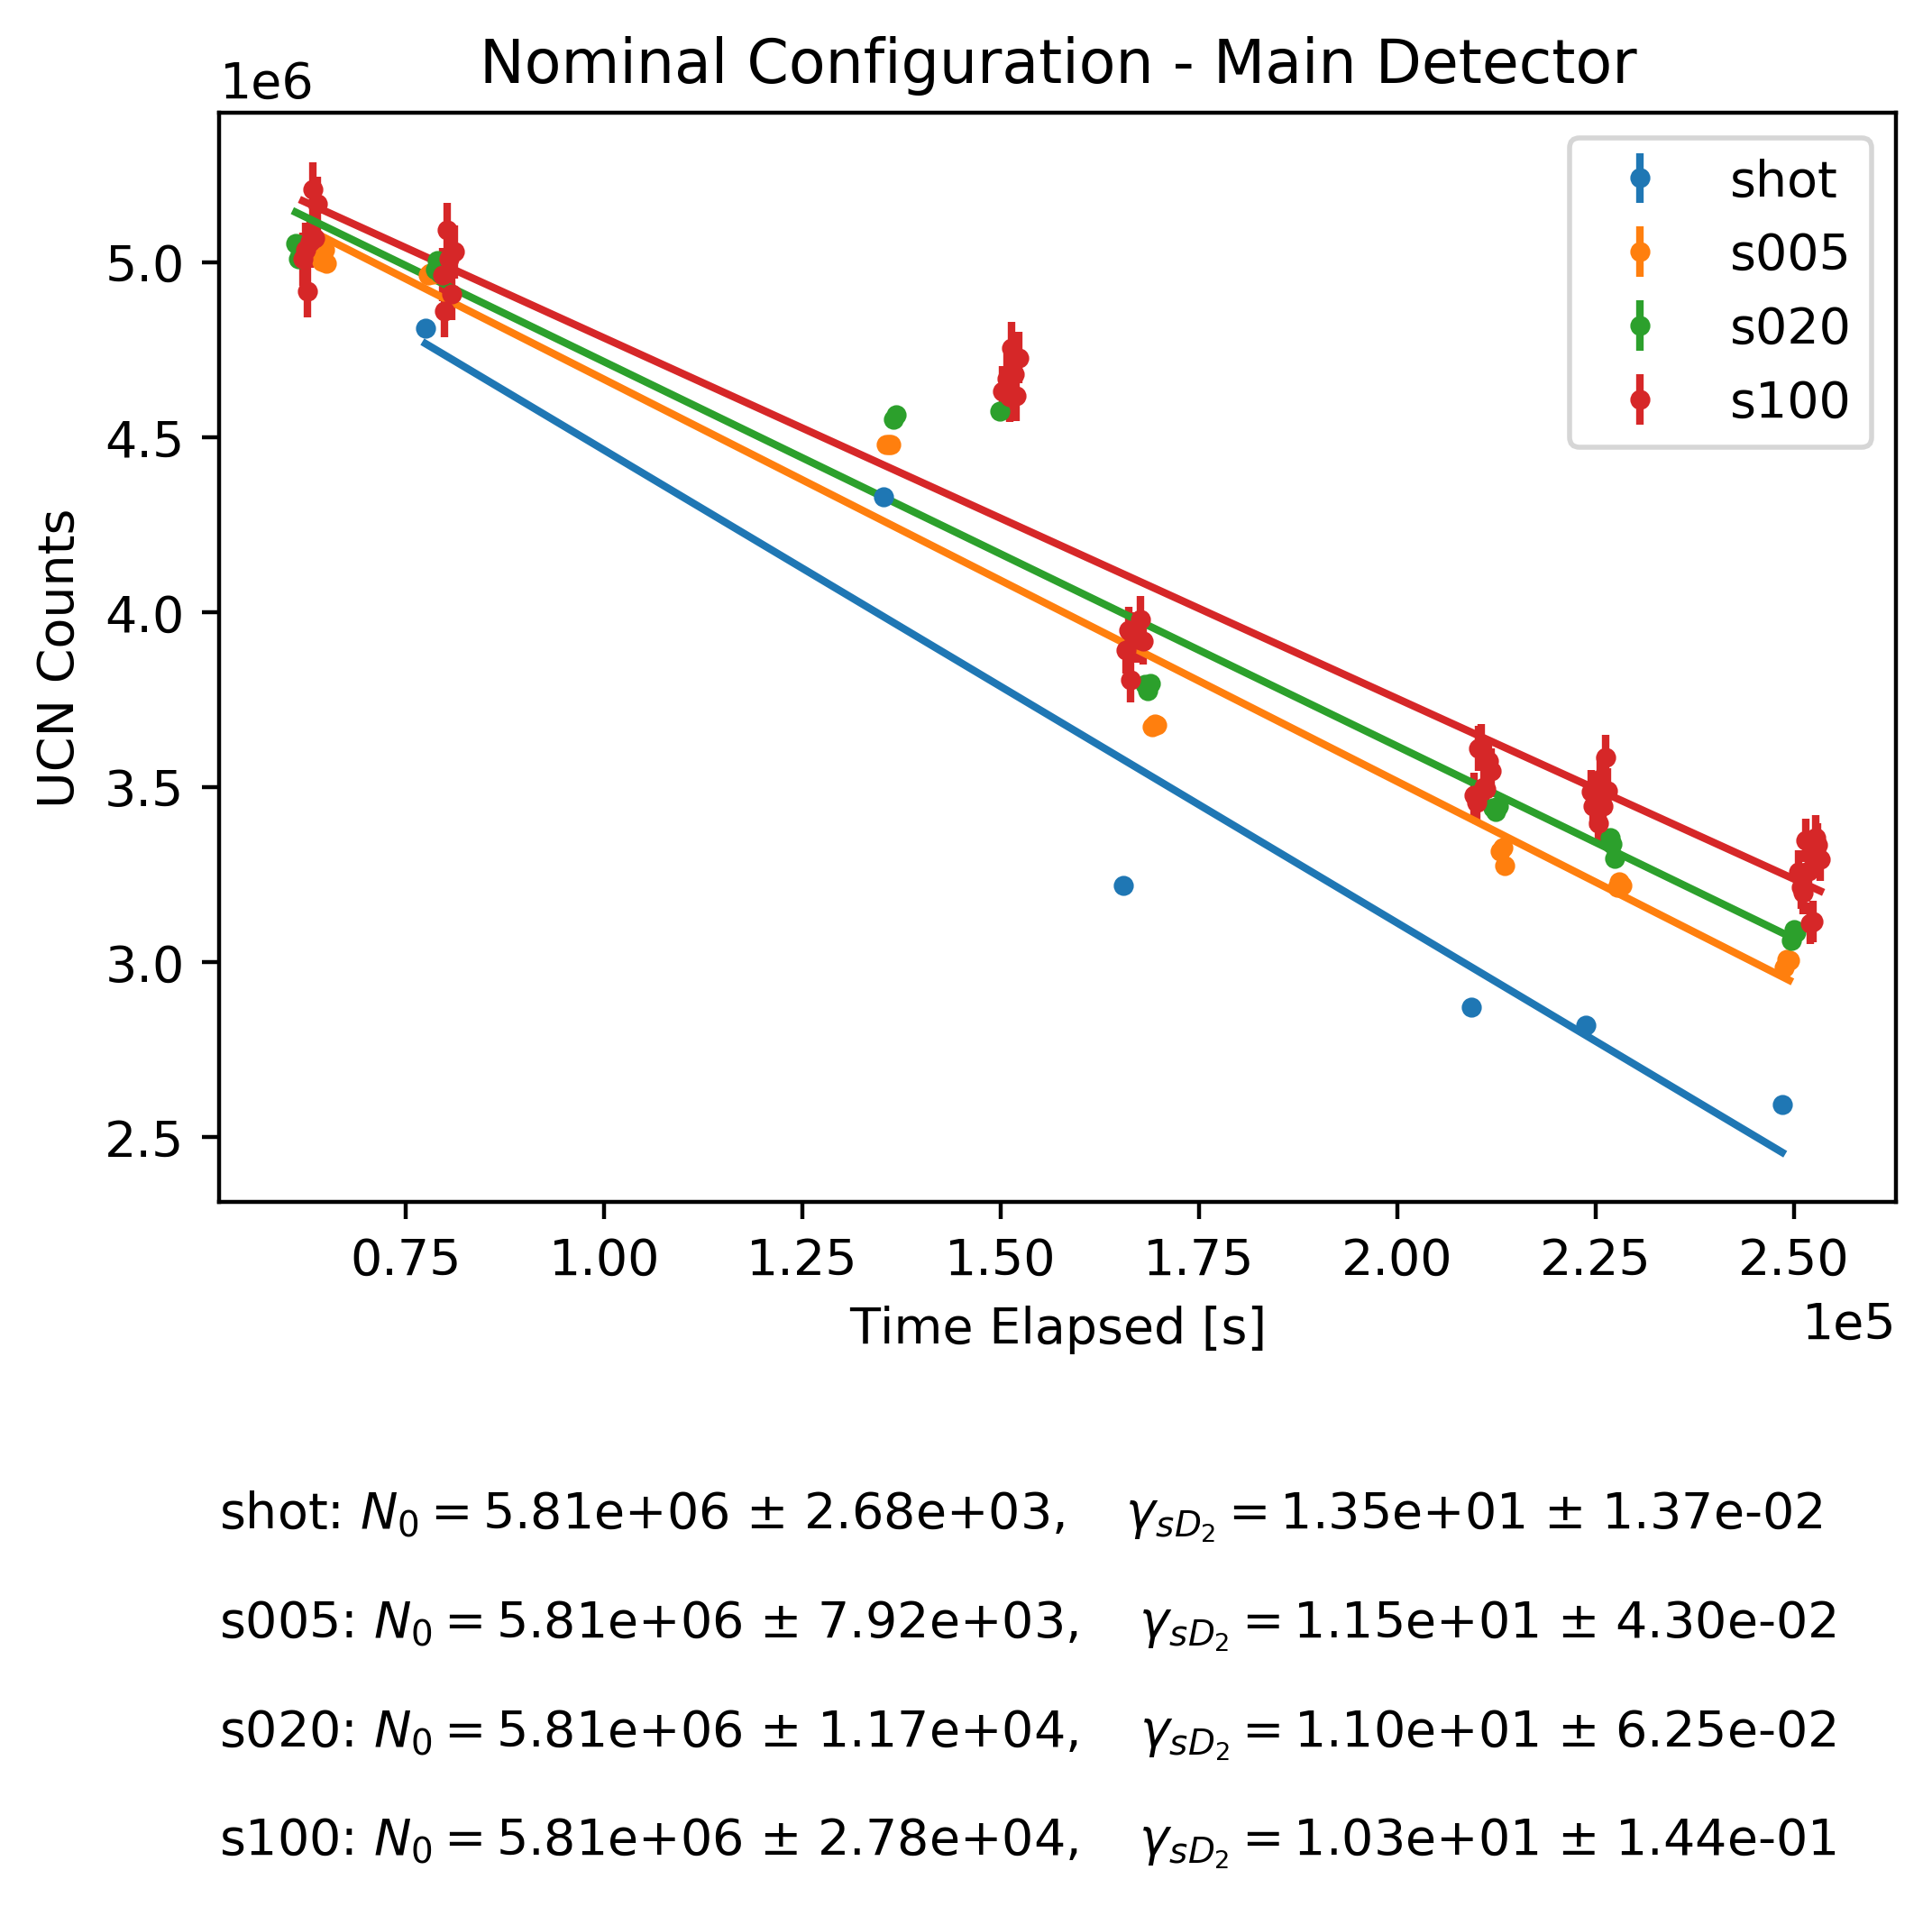

In [27]:
run_type_list = ['shot', 's005', 's020', 's100']

# for an all-in-one figure
fig, ax = plt.subplots()

# for counting loop iterations
text_y_coord = -0.2

# for colour consistency in plotting
ax_c = plt.gca()

for run_type in run_type_list:
    
    # defining a separate variable for more readable plotting code
    arr = main_data_dict.get(('NOMI', run_type))

    # compute the normalization factor
    norm_factor = norm_dict.get(('shot', 'N_0')) / norm_dict.get((run_type, 'N_0'))
    
    # for colour consistency in plotting
    color = next(ax_c._get_lines.prop_cycler)['color']

    # plotting the data by pre-storage time; separate figures
    ax.errorbar(arr[:,0], norm_factor * arr[:,2], yerr = norm_factor * arr[:,3], fmt = '.',
                label = run_type, color = color)

    # performing a linear fit
    popt, pcov = curve_fit(linear_fit, arr[:,0], norm_factor * arr[:,2], 
                        sigma = norm_factor * arr[:,3], absolute_sigma = True)

    ax.plot(arr[:,0], linear_fit(arr[:,0], *popt), color = color);

#     printing the fit results below the figure
    text_y_coord = text_y_coord - 0.1
    ax.text(0, text_y_coord, run_type + r': $N_0 = $%.2e $\pm $ %.2e$, \quad \gamma_{sD_2} = $%.2e $ \pm $ %.2e' % (
                decimal.Decimal(popt[0]), 
                decimal.Decimal(np.sqrt(np.diag(pcov))[0]),
                decimal.Decimal(popt[1]),
                decimal.Decimal(np.sqrt(np.diag(pcov))[1])),
                transform=ax.transAxes);

# presentation stuff
# ax.set_yscale('log')
ax.set_xlabel('Time Elapsed [s]');
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel('UCN Counts');
ax.legend();
ax.set_title('Nominal Configuration - Main Detector');

This doesn't make sense. Following this normalization we would expect the oppposite trend to be seen, namely that direct shot measurements are the most sensitive.

Bernhard's reflections on the normalization plot shown above:

> concerning your plot, this is interesting as I would have expected the opposite <br/>
we know and have several times measured,, that the build up of the frost on the<br/>
surface<br/>
see Anghel et al   Eur. Phys. J. A (2018) 54: 148<br/>
acts as energy filter - i.e. the longer the source is operated the intensity decreases and<br/>
the intensity decreases stronger for lower energy UCNs<br/>
therefore the longer storage times should be more strongly suppresed<br/>
 see Fig. 7 and 8 in the paper .<br/><br/>
In this paper you can also find, that it is not a decay of UCN production we observe but<br/>
an increase in losses due to buildup of frost on the surface- have a look.<br/><br/>
So my first thought would be, that there might be some effect in your analysis,<br/>
with is not yet considered or missing or unknown, which makes this change.<br/>
Might have to do something with monitoring, but I don;t know right away.<br/>
But one should certainly look at that closer.

The key figure from this paper that should cause some revisitation of the normalization analysis:

![](../misc/frost_paper_fig.png)
![](jonahberean/psi_transmission/misc/frost_paper_fig.png)

And from the paper:

>The West-1 beamport is located about 1.13 m and<br/>
the West-2 beamport 3.23 m above the sD 2 surface. This<br/>
results in a relative shift of the UCN energy spectra at the<br/>
two beamports. UCN which can reach the higher beam-<br/>
port have a minimum energy of 320 neV outside the sD 2<br/>
surface, while UCN at West-1 have a minimum energy of<br/>
113 neV, similar to the kinetic energy boost by the sD 2<br/>
potential [45,46].

So clearly we're getting this backwards, and the results need to be revisited.

# Propagating an Error associated with this Normalization

The error on an individual measurement, or run is given by Poisson statistics to be $\sqrt{N}$, where $N$ is the number of counts measured. From the four fits performed on this nominal configuration data, data in other configurations can be normalized based on the time stamp of their occurrence. The following normalization factor, $S$, will be used:

$$S = \frac{N_0^\mathrm{nom}}{N^\mathrm{nom}(t)}$$

where $N_0^\mathrm{nom}$ is the value of $N_0$ from the run-type-specific fit, and $N^\mathrm{nom}(t)$ is the value of $N$, counts, at time $t$ along the fit. The denominator term is an interpolation along the nominal configuration data fit, for run times of other runs, in other configurations. The error associated with $N_0^\mathrm{nom}$ is extracted from the fits above, and the error associated with $N^\mathrm{nom}(t)$ is simply propagated using the linear fit equation:

$$ \delta N^\mathrm{nom}(t) = \sqrt{\left (\delta N^\mathrm{nom}_0 \right )^2 + \left ( \delta \gamma^\mathrm{nom} \right )^2}$$

where the error a

The fractional uncertainty associated with the quantity $S$ as a whole is then:

\begin{align} 
\frac{\delta S}{S} = \sqrt{\left (\frac{\delta N_0^\mathrm{nom}}{N_0^\mathrm{nom}} \right )^2 + \left (\frac{\delta N^\mathrm{nom}(t)}{N^\mathrm{nom}(t)} \right )^2}
\end{align}

The counts for a single run, following normalization, are computed as $N' = N \cdot S$. This means that the resulting, fractional, statistical uncertainty on counts for a single run will be

\begin{align} 
\frac{\delta N'}{N'} = \sqrt{\left (\frac{\delta N}{N} \right )^2 + \left (\frac{\delta S}{S} \right )^2}
\end{align}

# Using the Spread of Re-Scaled Loss Rates as an Error Bar

Alternatively, the spread of these re-scaled loss rate values could be used to define an error bar on the normalization itself. If this is done, a pre-storage lifetime measurement using nominal configuration data yields the following plot.

(!!!)

(Do the error bars better represent the spread of the data?)

# Time (therefore Energy?) Bin - Absolute Dependent UCN Detection 

Perhaps a more granular view is achieved from an analysis that looks at how specific time bins perform over time.

# Analysis of the Monitor Detector Counts

Thus far we have only reviewed the data from the main detector, but we could also look at the data from the monitor detector that is attached to the source vessel. 

(!!! heights from the EPJ paper, do we see the correct relative count rate magnitudes between the monitor and main on a direct shot?)

(!!! explanatory schematic)

(!!! could the cyclotron beam timing data tell us something about what happened during the low count period of the monitor detector? If Bernhard is right, then that mis-synchronization should be observable)

(!!! multiple fits)

# Conclusions